In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler as StandardScaler

In [2]:
%%capture
'''# import warnings filter (for irgnoring future warning for normalization in sklearn model)
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)'''

In [3]:
# dataset origin: https://www.kaggle.com/datasets/deepcontractor/car-price-prediction-challenge
# load dataset
df= pd.read_csv('/kaggle/input/car-price-prediction-challenge/car_price_prediction.csv')

# Inspect and Clean Dataset

In [4]:
df.shape

(19237, 18)

In [5]:
df.head()

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


In [6]:
# remove duplicate rows, if any
df = df.drop_duplicates()
df.shape

(18924, 18)

In [7]:
df.describe()

,ID,Price,Prod. year,Cylinders,Airbags
count,1.892400e+04,1.892400e+04,18924.000000,18924.000000,18924.000000
mean,4.557538e+07,1.858744e+04,2010.914236,4.580216,6.568379
std,9.375468e+05,1.921356e+05,5.665749,1.200223,4.322323
min,2.074688e+07,1.000000e+00,1939.000000,1.000000,0.000000
25%,4.569501e+07,5.331000e+03,2009.000000,4.000000,4.000000
50%,4.577191e+07,1.317200e+04,2012.000000,4.000000,6.000000
75%,4.580174e+07,2.206300e+04,2015.000000,4.000000,12.000000
max,4.581665e+07,2.630750e+07,2020.000000,16.000000,16.000000


In [8]:
df.isnull().any()

ID                  False
Price               False
Levy                False
Manufacturer        False
Model               False
Prod. year          False
Category            False
Leather interior    False
Fuel type           False
Engine volume       False
Mileage             False
Cylinders           False
Gear box type       False
Drive wheels        False
Doors               False
Wheel               False
Color               False
Airbags             False
dtype: bool

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18924 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                18924 non-null  int64  
 1   Price             18924 non-null  int64  
 2   Levy              18924 non-null  object 
 3   Manufacturer      18924 non-null  object 
 4   Model             18924 non-null  object 
 5   Prod. year        18924 non-null  int64  
 6   Category          18924 non-null  object 
 7   Leather interior  18924 non-null  object 
 8   Fuel type         18924 non-null  object 
 9   Engine volume     18924 non-null  object 
 10  Mileage           18924 non-null  object 
 11  Cylinders         18924 non-null  float64
 12  Gear box type     18924 non-null  object 
 13  Drive wheels      18924 non-null  object 
 14  Doors             18924 non-null  object 
 15  Wheel             18924 non-null  object 
 16  Color             18924 non-null  object

1) Columns Levy, Engine volume and Mileage would be expected to be numeric -> search for non-numeric values
2) Doors: dates need to be replaced with plausible values

In [10]:
# as could be seen by the .head(), some entries in Levy are '-', which we will interpret as 0
df['Levy'] = df['Levy'].replace('-', 0)
df['Levy'] = pd.to_numeric(df['Levy'], errors='coerce')
#df.info()  # check, if conversion worked

In [11]:
df['Engine volume']

0              3.5
1                3
2              1.3
3              2.5
4              1.3
           ...    
19232    2.0 Turbo
19233          2.4
19234            2
19235            2
19236          2.4
Name: Engine volume, Length: 18924, dtype: object

In [12]:
# because of the string ' Turbo' this column is not numeric. Instead of just removing the string, we add a new column to encode
# this information as a categorical variable before removing from column 'Engine volume'
df['Turbo'] = [1 if 'Turbo' in x else 0 for x in df['Engine volume']]
df['Engine volume'] = df['Engine volume'].replace(' Turbo', '', regex=True)
df['Engine volume'] = pd.to_numeric(df['Engine volume'], errors='coerce')
df['Engine volume'].isnull().any()  # check, if conversion to numeric column worked or if there are more strings to take care of

False

In [13]:
# clean Mileage column, as ' km' was present in the cells displayed with .head()
df['Mileage'] = df['Mileage'].replace(' km', '', regex=True)
df['Mileage'] = pd.to_numeric(df['Mileage'], errors='coerce')
df['Mileage'].isnull().any()  # check, if conversion to numeric column worked or if there are more strings to take care of

False

In [14]:
df['Doors'].value_counts()

04-May    18032
02-Mar      768
>5          124
Name: Doors, dtype: int64

In [15]:
# there are 3 values, which are interpreted as dates. 
# 02-Mar is most likely 2-3, 04-May is most likely 4-5, >5 makes sense
df.loc[df['Doors'] == '04-May', 'Doors'] = '4-5'
df.loc[df['Doors'] == '02-Mar', 'Doors'] = '2-3'
df['Doors'].value_counts()

4-5    18032
2-3      768
>5       124
Name: Doors, dtype: int64

In [16]:
# replace production year with age of car instead by year of publication - prodYear (no publication date found, 2021 is assumed)
df['Age'] = 2021 - df['Prod. year']
df['Age']

0        11
1        10
2        15
3        10
4         7
         ..
19232    22
19233    10
19234    11
19235    14
19236     9
Name: Age, Length: 18924, dtype: int64

In [17]:
df = df.drop(['ID', 'Prod. year'], axis=1)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18924 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             18924 non-null  int64  
 1   Levy              18924 non-null  int64  
 2   Manufacturer      18924 non-null  object 
 3   Model             18924 non-null  object 
 4   Category          18924 non-null  object 
 5   Leather interior  18924 non-null  object 
 6   Fuel type         18924 non-null  object 
 7   Engine volume     18924 non-null  float64
 8   Mileage           18924 non-null  int64  
 9   Cylinders         18924 non-null  float64
 10  Gear box type     18924 non-null  object 
 11  Drive wheels      18924 non-null  object 
 12  Doors             18924 non-null  object 
 13  Wheel             18924 non-null  object 
 14  Color             18924 non-null  object 
 15  Airbags           18924 non-null  int64  
 16  Turbo             18924 non-null  int64 

In [19]:
df.describe(())

,Price,Levy,Engine volume,Mileage,Cylinders,Airbags,Turbo,Age
count,1.892400e+04,18924.000000,18924.000000,1.892400e+04,18924.000000,18924.000000,18924.000000,18924.000000
mean,1.858744e+04,632.886493,2.306251,1.555373e+06,4.580216,6.568379,0.099979,10.085764
std,1.921356e+05,568.273736,0.877591,4.880221e+07,1.200223,4.322323,0.299980,5.665749
min,1.000000e+00,0.000000,0.000000,0.000000e+00,1.000000,0.000000,0.000000,1.000000
50%,1.317200e+04,642.000000,2.000000,1.264000e+05,4.000000,6.000000,0.000000,9.000000
max,2.630750e+07,11714.000000,20.000000,2.147484e+09,16.000000,16.000000,1.000000,82.000000


array([[<AxesSubplot:title={'center':'Price'}>,
        <AxesSubplot:title={'center':'Levy'}>,
        <AxesSubplot:title={'center':'Engine volume'}>],
       [<AxesSubplot:title={'center':'Mileage'}>,
        <AxesSubplot:title={'center':'Cylinders'}>,
        <AxesSubplot:title={'center':'Airbags'}>],
       [<AxesSubplot:title={'center':'Turbo'}>,
        <AxesSubplot:title={'center':'Age'}>, <AxesSubplot:>]],
      dtype=object)

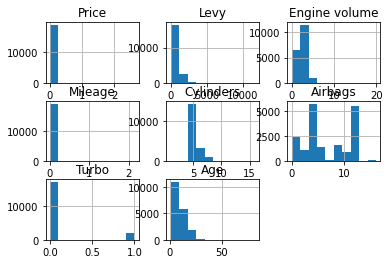

In [20]:
df.hist()

In [21]:
df['Category'].value_counts()

Sedan          8600
Jeep           5378
Hatchback      2799
Minivan         633
Coupe           528
Universal       361
Microbus        299
Goods wagon     229
Pickup           51
Cabriolet        35
Limousine        11
Name: Category, dtype: int64

In [22]:
df = df.drop(df[df['Category'] == 'Goods wagon'].index)  # remove goods wagons as we are only interested in passenger cars
df['Category'].value_counts()

Sedan        8600
Jeep         5378
Hatchback    2799
Minivan       633
Coupe         528
Universal     361
Microbus      299
Pickup         51
Cabriolet      35
Limousine      11
Name: Category, dtype: int64

# Analysis

In [23]:
cars_per_year = df.groupby('Age').count()['Price']
cars_per_year

Age
1       47
2      304
3      490
4      941
5     1449
6     1527
7     2088
8     1910
9     2125
10    1571
11    1452
12     581
13     717
14     446
15     307
16     382
17     336
18     335
19     275
20     244
21     262
22     192
23     189
24     139
25     102
26      98
27      40
28      23
29      29
30      10
31      18
32       6
33      12
34       5
35       6
36       5
37       4
38       3
39       1
40       1
41       2
43       1
44       2
45       1
47       1
48       1
53       1
56       2
57       2
64       1
68       4
74       1
78       1
82       3
Name: Price, dtype: int64

In [24]:
df.groupby('Age').mean().astype(int)['Price']

Age
1      63006
2      30746
3      35458
4      26999
5      28336
6      20918
7      17920
8      16695
9      15352
10     14029
11     14289
12     13679
13     11340
14     13132
15     12913
16     10957
17     11343
18      9905
19      9265
20      8598
21      8182
22      7695
23      7353
24      6399
25      6540
26      6269
27      6036
28      6407
29      5748
30      4746
31      5215
32      3546
33      4849
34      8828
35      4906
36      2995
37      3881
38      1300
39     31361
40      2800
41      1925
43      1300
44     10340
45       400
47      2437
48     15681
53      2200
56     65074
57      6585
64      7527
68     17735
74       150
78    119172
82       171
Name: Price, dtype: int64

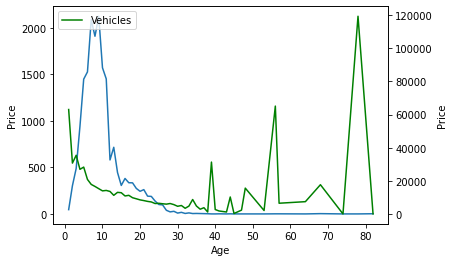

In [25]:
ax = sns.lineplot(data=cars_per_year, ci=None)
ax2=ax.twinx()
sns.lineplot(x='Age', y='Price', data=df, ax=ax2, color='g', ci=None)
ax.xlabel='Age'
ax.ylabel='Vehicles'
ax2.ylabel='Price'
plt.legend(labels=['Vehicles', 'Mean Price per Vehicle'])

<AxesSubplot:xlabel='Age', ylabel='Price'>

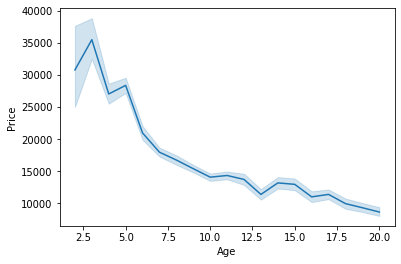

In [26]:
# to not be affected by outliers too much, we restrict our analysis to ages with >100 cars (cutoff). This would be cars aged 
# 2 - 26 years.
# as we can see that the mean price has an outlier for 22 years old cars and fluctuates a lot afterwards, 
# we'll cut off at 20 years for our analysis. Cars older than 20 years are hardly relevant for the average buyer and 
# vintage car prices would be worth a separate analysis (which this dataset is not suited for)
df = df[df['Age'] >1]  # remove cars <1 years as there are fewer than 100 cars in the dataset
df = df[df['Age'] <=20]  # remove cars <20 years for the reasons mentioned above
sns.lineplot(x='Age', y='Price', data=df)

In [27]:
df = df[df['Price'] <= df['Price'].quantile(0.99)]  # eliminate outliers (excessively expensive cars) to focus on the main market
df = df[df['Price'] >= df['Price'].quantile(0.01)]  # eliminate outliers (excessively cheap cars) to focus on the main market

<AxesSubplot:>

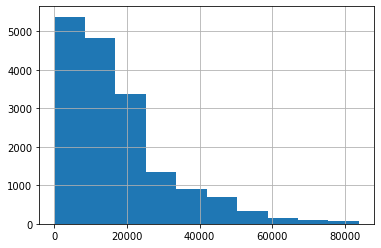

In [28]:
df['Price'].hist()

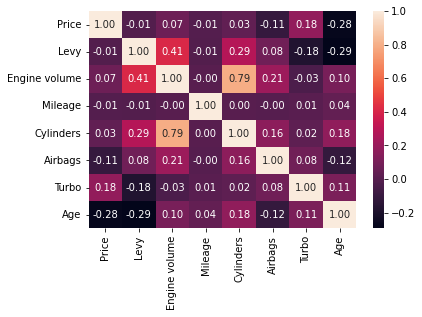

In [29]:
sns.heatmap(df.corr(), annot=True, fmt=".2f");

In [30]:
# encode numerical variables
df_before_encoding = df.copy()  # store for subsequent analysis of unencoded df
df_cat = df.select_dtypes(include=['object']).copy()
df_cat = df_cat.drop('Model', axis=1)  # remove column Model to not drastically overfit
df_cat = df_cat.drop('Manufacturer', axis=1)  # remove column Manufacturer to not drastically overfit
df_cat = pd.get_dummies(df_cat, drop_first=True)
df_cat.shape

(17159, 39)

In [31]:
# with 40 columns (due to encoding) and 17315 rows, our dataset is big enough to satisfy the rule of thumb of >10 rows per column
df = df.drop(df.select_dtypes(include=['object']).columns, axis=1)
df = pd.concat([df, df_cat], axis=1)

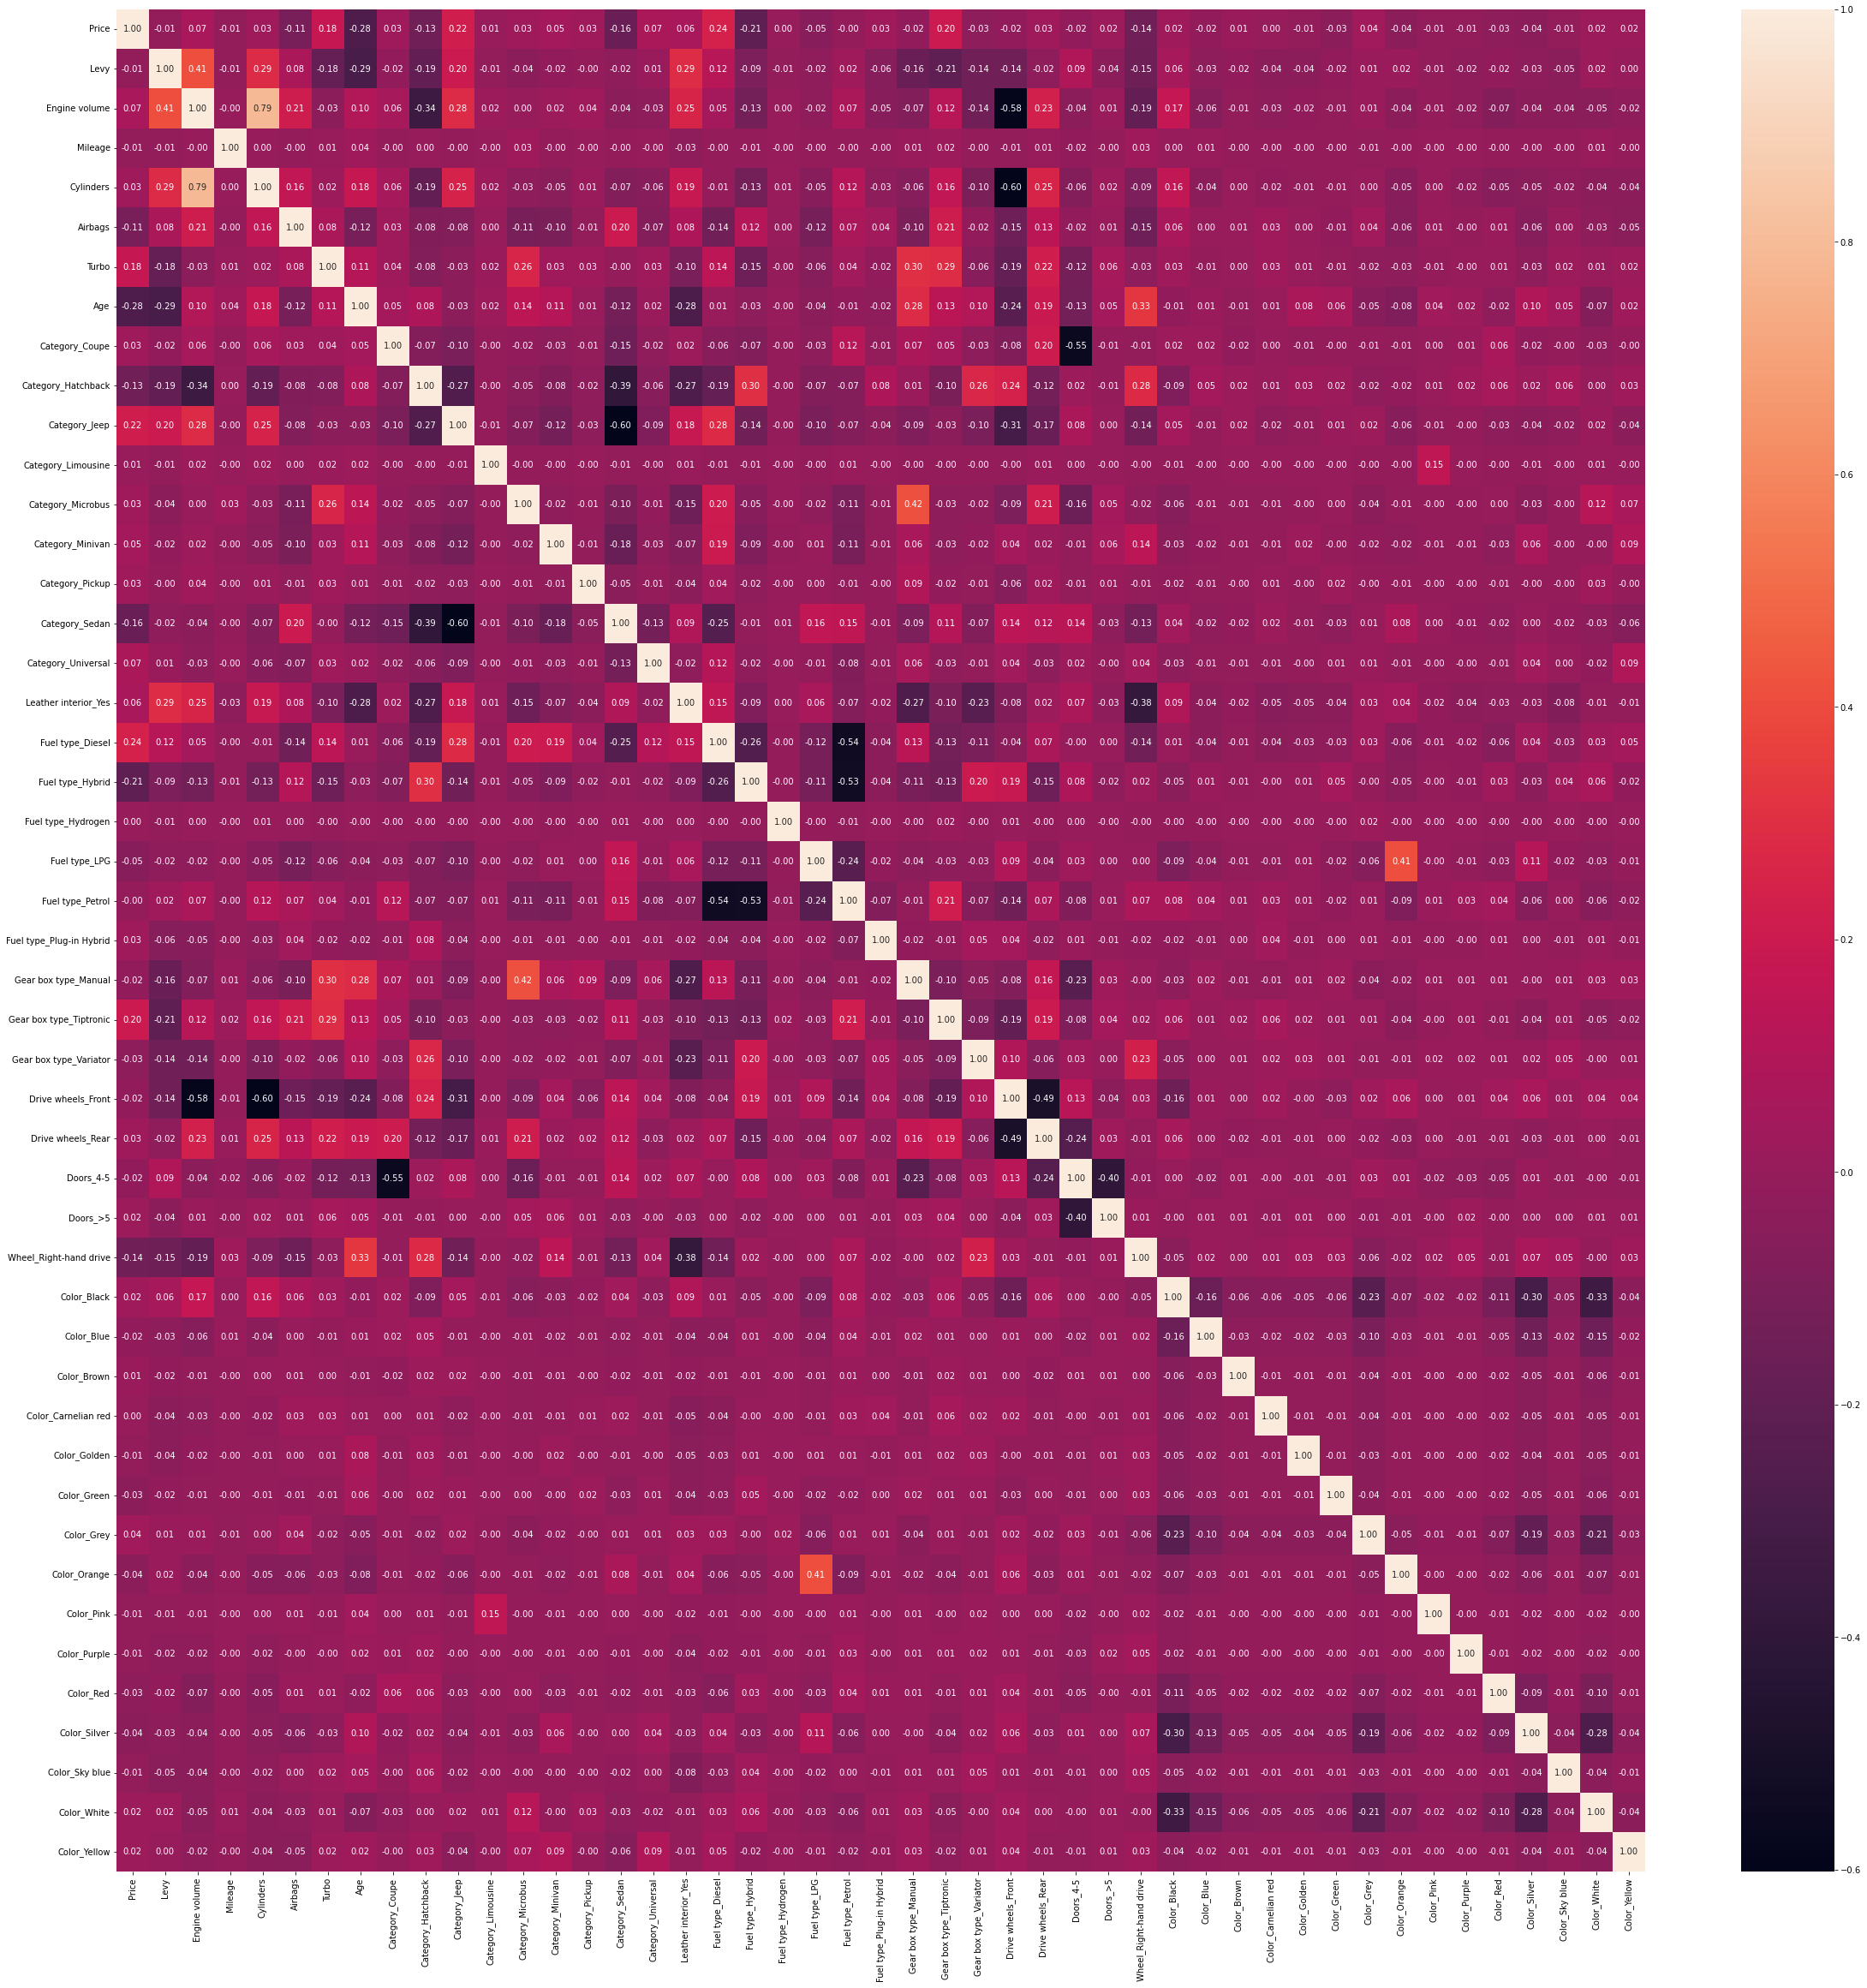

In [32]:
fig, ax = plt.subplots(figsize=(40,40))
sns.heatmap(df.corr(), annot=True, fmt=".2f");

In [33]:
# as can be seen from the matrix, not all features are uncorrelated to one-another, 
# e.g. Jeep and Diesel habe a relatively strong correlation (both of which have a strong correlation with price)

In [34]:
df.corr()['Price'].sort_values(key=abs, ascending=False)

Price                       1.000000
Age                        -0.275837
Fuel type_Diesel            0.241546
Category_Jeep               0.219697
Fuel type_Hybrid           -0.206176
Gear box type_Tiptronic     0.195150
Turbo                       0.176182
Category_Sedan             -0.164084
Wheel_Right-hand drive     -0.138322
Category_Hatchback         -0.133978
Airbags                    -0.107843
Category_Universal          0.071862
Engine volume               0.065447
Leather interior_Yes        0.063857
Category_Minivan            0.052265
Fuel type_LPG              -0.051639
Color_Silver               -0.044037
Color_Orange               -0.039543
Color_Grey                  0.039169
Cylinders                   0.033945
Category_Microbus           0.033928
Color_Green                -0.033730
Gear box type_Variator     -0.029070
Fuel type_Plug-in Hybrid    0.028475
Color_Red                  -0.028297
Category_Pickup             0.027834
Category_Coupe              0.027795
D

In [35]:
#0) create vectors and split dataset
X = df.drop(['Price'], axis=1)
y = df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)

#1) Instantiate
#lm_model = LinearRegression(normalize=True) 
lm_model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

#2) Fit
lm_model.fit(X_train, y_train)

#3) Predict
y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train)

#4) Score
r2_test = r2_score(y_pred=y_test_preds, y_true=y_test)  # Rsquared
r2_train = r2_score(y_pred=y_train_preds, y_true=y_train)  # Rsquared

In [36]:
r2_train

0.33615108518619785

<AxesSubplot:xlabel='Price'>

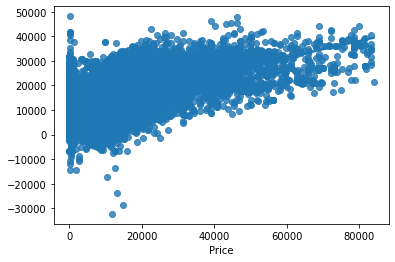

In [37]:
sns.regplot(x=y_train, y=y_train_preds)

In [38]:
r2_test

0.3145778501162083

<AxesSubplot:xlabel='Price'>

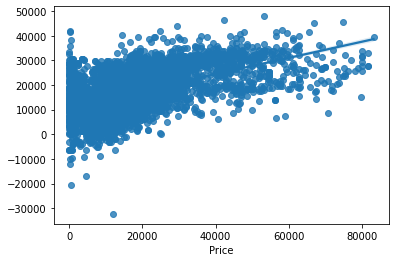

In [39]:
sns.regplot(x=y_test, y=y_test_preds)

In [40]:
# the model even provides negative prices

In [41]:
df_before_encoding['Fuel type'].value_counts()

Petrol            8955
Diesel            3591
Hybrid            3494
LPG                833
CNG                202
Plug-in Hybrid      83
Hydrogen             1
Name: Fuel type, dtype: int64

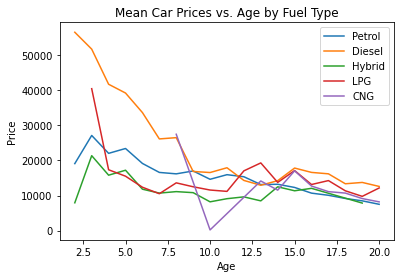

In [42]:
sns.lineplot(x='Age', y='Price', data=df_before_encoding[df_before_encoding['Fuel type'] == 'Petrol'], ci=None)
sns.lineplot(x='Age', y='Price', data=df_before_encoding[df_before_encoding['Fuel type'] == 'Diesel'], ci=None)
sns.lineplot(x='Age', y='Price', data=df_before_encoding[df_before_encoding['Fuel type'] == 'Hybrid'], ci=None)
sns.lineplot(x='Age', y='Price', data=df_before_encoding[df_before_encoding['Fuel type'] == 'LPG'], ci=None)
sns.lineplot(x='Age', y='Price', data=df_before_encoding[df_before_encoding['Fuel type'] == 'CNG'], ci=None)
# sns.lineplot(x='Age', y='Price', data=df_before_encoding[df_before_encoding['Fuel type'] == 'Plug-in hybrid'], ci=None)  # ignore, only 83 cars in sample
# sns.lineplot(x='Age', y='Price', data=df_before_encoding[df_before_encoding['Fuel type'] == 'Hydrogen'], ci=None)  # ignore, only 1 car in sample

plt.title(label='Mean Car Prices vs. Age by Fuel Type')
plt.legend(labels=['Petrol', 'Diesel','Hybrid', 'LPG', 'CNG'])
plt.show()

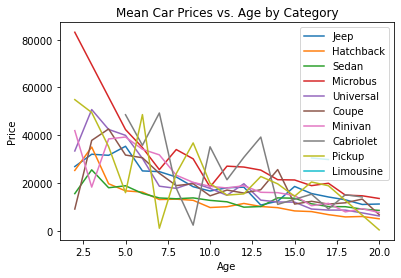

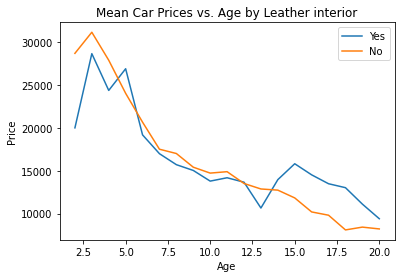

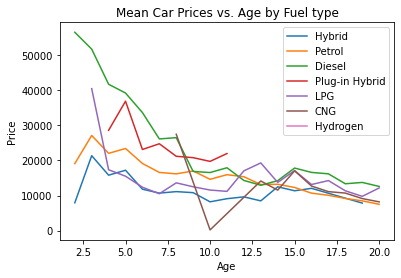

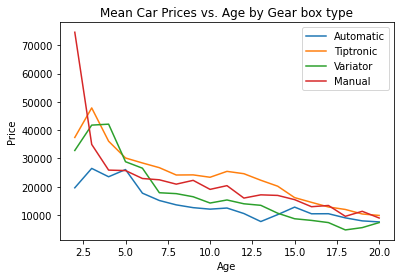

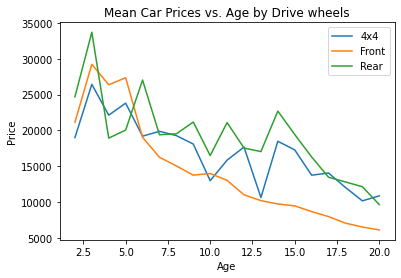

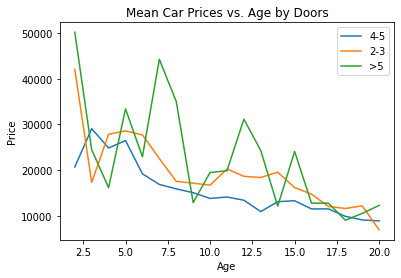

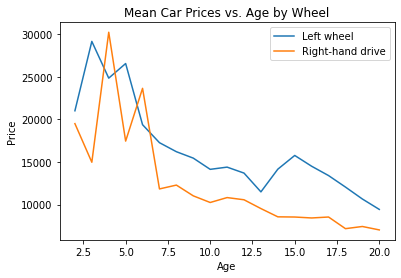

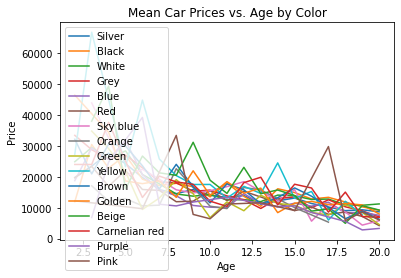

In [43]:
col_name = df_before_encoding.columns.to_list()
for col in df_before_encoding.select_dtypes(exclude=['object']).columns.to_list():
    col_name.remove(col)
col_name.remove('Manufacturer')
col_name.remove('Model')
#col_name = ['Fuel type', 'Category']
for col in col_name:
    plt.figure()
    series = df_before_encoding[col].unique().tolist()
    for entry in series:
        sns.lineplot(x='Age', y='Price', data=df_before_encoding[df_before_encoding[col] == entry], ci=None)
    plt.title(label='Mean Car Prices vs. Age by ' + col)
    plt.legend(labels=series)